In [67]:
import pandas as pd
import numpy as np
import json
import os
import sys
from pathlib import Path

sys.path.append("..")
from common.constants import DATAFOLDER, COLUMNS
# from preprocess.src.preprocess import main
parent_dir = Path(os.path.abspath(""))
print(parent_dir.parent)
sys.path.append(parent_dir.parent)
sys.path.append(os.path.join(parent_dir.parent, "preprocess"))
from preprocess.src.feature_aggregation import agg_feature
from preprocess.src.features import sma, std
from preprocess.src.label_features import position_label

coin_name = "BTCUSDT"
data_file_path = os.path.join(
    DATAFOLDER.cleaned_data_root_path,
    coin_name,
    f"{coin_name}.parquet.gzip",
)
df = pd.read_parquet(data_file_path, engine="pyarrow")
df.head()

/Users/akiranoda/projects/crypto_model


,Open,High,Low,Close,Volume,CloseTime,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume,Ignore
OpenTime,,,,,,,,,,,
1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,1502943299999,9333.620962,9,0.489061,2089.104962,7958.417415
1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,1502944199999,38891.133046,40,3.447113,14703.934995,7922.579933
1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,1502945099999,94080.917568,58,20.421317,87620.977876,7912.494217
1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,1502945999999,60060.466816,64,10.803012,46538.460109,7887.635513
1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,1502946899999,22006.533111,44,3.496635,15093.783057,7865.654419


In [68]:
feature_columns = []
df["sma5"] = sma(df, 5)
df["sma25"] = sma(df, 25)
df["sma50"] = sma(df, 50)
df["sma100"] = sma(df, 100)
feature_columns += [f"sma{i}" for i in [5, 25, 50, 100]]

df["std10"] = std(df, 10)
df["std25"] = std(df, 25)
df["std50"] = std(df, 50)
feature_columns += [f"std{i}" for i in [10, 25, 50]]

df["sma5_20_deviation_rate"] = 100 * (1 - sma(df, 20)) / sma(df, 5)
df["sma10_30_deviation_rate"] = 100 * (1 - sma(df, 30)) / sma(df, 10)
df["sma25_50_deviation_rate"] = 100 * (1 - sma(df, 50)) / sma(df, 25)
feature_columns += [f"sma{i}_{j}_deviation_rate" for i, j in zip([5, 10, 25], [20, 30, 50])]

# labels
df["y_buy"], df["buy_cost"], df["y_sell"], df["sell_cost"], df["buy_executed"], df["sell_executed"], df["buy_fet"], df["sell_fet"] = position_label(
    df, pips=1.0, fee_percent=0.1, horizon_barrier=1, executionType="check"
)

feature_columns += ["y_buy", "buy_cost", "y_sell", "sell_cost", "buy_executed", "sell_executed", "buy_fet", "sell_fet"]
df = df.dropna()
df = df[feature_columns]

In [69]:
df.head(30)

,sma5,sma25,sma50,sma100,std10,std25,std50,sma5_20_deviation_rate,sma10_30_deviation_rate,sma25_50_deviation_rate,y_buy,buy_cost,y_sell,sell_cost,buy_executed,sell_executed,buy_fet,sell_fet
OpenTime,,,,,,,,,,,,,,,,,,
1502986500,1.012645,1.030127,1.019030,1.019030,70.595967,49.377823,67.435895,-2.836360,-2.821722,-1.847305,0.000000,0.000000,-0.005944,-0.004361,0.0,1.0,3.0,1.0
1502987400,1.003607,1.025859,1.016268,1.015712,76.712424,55.790479,66.219469,-2.370147,-2.502980,-1.585840,0.000000,0.000000,-0.003594,-0.004348,0.0,1.0,2.0,1.0
1502988300,0.998520,1.022095,1.013525,1.012421,73.140692,57.555440,63.980504,-1.977618,-2.196999,-1.323298,-0.005134,-0.004512,0.000000,0.000000,1.0,0.0,1.0,11.0
1502989200,0.994865,1.017780,1.010475,1.009058,66.162182,59.233618,63.375927,-1.545434,-1.818230,-1.029226,-0.002162,-0.004528,0.000000,0.000000,1.0,0.0,1.0,10.0
1502990100,0.999093,1.019488,1.013573,1.011837,56.504464,60.232761,62.823324,-1.742373,-2.033231,-1.331354,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,9.0
1502991000,0.997777,1.014910,1.010572,1.008516,43.721483,60.515039,62.271632,-1.312848,-1.677504,-1.041662,0.001128,-0.004776,0.000000,0.000000,1.0,0.0,1.0,8.0
1502991900,1.011171,1.027371,1.024517,1.022205,33.846072,63.315148,63.097482,-2.551660,-2.945779,-2.386402,0.010756,-0.005295,0.000000,0.000000,1.0,0.0,1.0,7.0
1502992800,1.014415,1.032733,1.031180,1.028505,27.347513,67.131471,63.385368,-3.015910,-3.495956,-3.019186,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,6.0
1502993700,1.003922,1.023158,1.022927,1.020050,25.948062,69.514145,64.135469,-2.061756,-2.584514,-2.240838,0.011600,-0.005764,0.000000,0.000000,1.0,0.0,1.0,5.0


In [70]:
df.describe()

,sma5,sma25,sma50,sma100,std10,std25,std50,sma5_20_deviation_rate,sma10_30_deviation_rate,sma25_50_deviation_rate,y_buy,buy_cost,y_sell,sell_cost,buy_executed,sell_executed,buy_fet,sell_fet
count,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000,118301.000000
mean,1.000072,1.000010,0.999922,0.999758,37.649410,57.927153,81.574979,0.000187,0.007733,0.025656,-0.000542,-0.000717,-0.000623,-0.000688,0.385500,0.373353,2.694449,2.966628
std,0.004250,0.012033,0.017111,0.024963,51.684107,73.200835,95.049311,1.064530,1.313805,1.692431,0.004875,0.001742,0.004436,0.001699,0.486715,0.483697,2.190150,5.764174
min,0.899872,0.847767,0.852019,0.799223,0.000000,0.000000,0.000000,-23.138135,-28.518556,-31.004152,-0.127868,-0.038319,-0.232941,-0.042017,0.000000,0.000000,1.000000,1.000000
25%,0.998705,0.996075,0.993778,0.989843,11.474933,17.549101,25.580345,-0.295599,-0.369913,-0.497927,0.000000,-0.000700,0.000000,-0.000638,0.000000,0.000000,1.000000,1.000000
50%,0.999976,0.999708,0.999459,0.999128,20.747515,33.193479,49.774772,0.022717,0.034589,0.054137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,1.001278,1.003324,1.004994,1.007915,42.088965,67.885365,98.747841,0.342784,0.441062,0.624424,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,4.000000
max,1.110797,1.286528,1.397649,1.585701,826.050481,904.861222,893.224660,15.020434,17.043694,17.064760,0.100502,0.000956,0.108563,0.000956,1.000000,1.000000,24.000000,216.000000


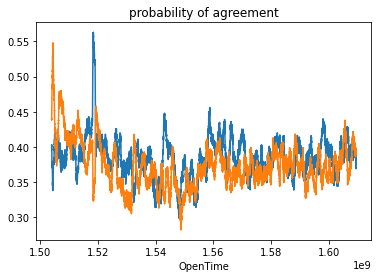

In [71]:
import matplotlib.pyplot as plt

# probability of make
df["buy_executed"].rolling(1000).mean().plot(label="buy")
df["sell_executed"].rolling(1000).mean().plot(label="sell")
plt.title("probability of agreement")
plt.show()
plt.close()

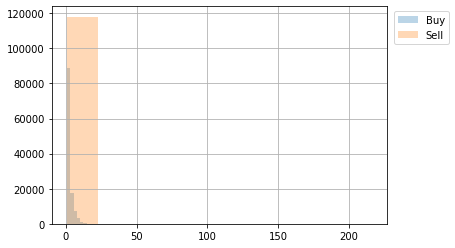

In [72]:
df['buy_fet'].hist(alpha=0.3, label='Buy')
df['sell_fet'].hist(alpha=0.3, label='Sell')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

Count of +Return y_buy 16739
Count of -Return y_buy 28866
Count of +Return y_sell 15240
Count of -Return y_sell 28928


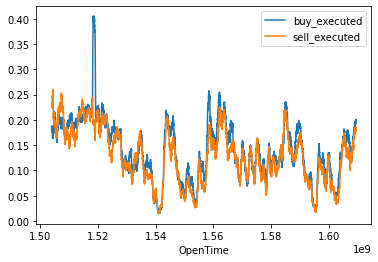

In [73]:
y_buy_positive = df["y_buy"] > 0
y_buy_negative = df["y_buy"] < 0
y_sell_positive = df["y_sell"] > 0
y_sell_negative = df["y_sell"] < 0

print("Count of +Return y_buy", y_buy_positive.value_counts()[1])
print("Count of -Return y_buy", y_buy_negative.value_counts()[1])
print("Count of +Return y_sell", y_sell_positive.value_counts()[1])
print("Count of -Return y_sell", y_sell_negative.value_counts()[1])

y_buy_positive.rolling(1000).mean().plot(label="buy_executed")
y_sell_positive.rolling(1000).mean().plot(label="sell_executed")

plt.legend()
plt.show()
plt.close()

In [74]:
df["y_buy_cumsum"] = df["y_buy"].cumsum()
df[["y_buy", "y_buy_cumsum"]].tail(50)

,y_buy,y_buy_cumsum
OpenTime,,
1609412400,0.000000,-64.071626
1609413300,0.000000,-64.071626
1609414200,0.000246,-64.071380
1609415100,0.000000,-64.071380
1609416000,0.000000,-64.071380
1609416900,0.000000,-64.071380
1609417800,-0.023788,-64.095168
1609418700,-0.013561,-64.108729
1609419600,0.000000,-64.108729


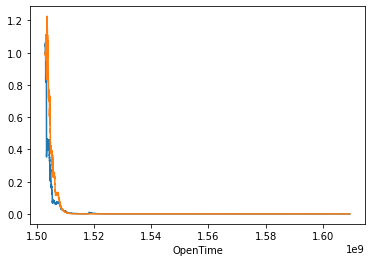

In [75]:
# cumulative return
buy_cum_return = (df["y_buy"] + 1).cumprod().plot(label="buy")
sell_cum_return = (df["y_sell"] + 1).cumprod().plot(label="sell")

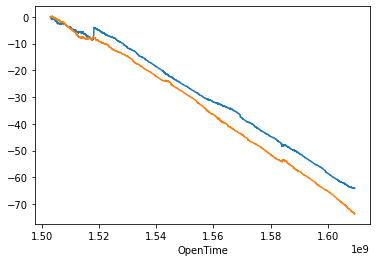

In [76]:
# cumulative return
buy_cum_return = df["y_buy"].cumsum().plot(label="buy")
sell_cum_return = df["y_sell"].cumsum().plot(label="sell")

In [77]:
buy_pos_return_average = df.loc[df["y_buy"] > 0]["y_buy"].mean()
buy_neg_return_average = df.loc[df["y_buy"] < 0]["y_buy"].mean()
print("+Return:", buy_pos_return_average, "-Return:", buy_neg_return_average)
print(df["y_buy_cumsum"].values[-1], y_buy_positive.value_counts()[0] * buy_neg_return_average + y_buy_positive.value_counts()[1] * buy_pos_return_average)
print(df["y_buy"].sum())

+Return: 0.003911351636388279 -Return: -0.004489448515683051
-64.12030581219989 -390.48525510829865
-64.12030581220354


In [78]:
len(df.loc[df["y_buy"] > 0]["y_buy"]) + len(df.loc[df["y_buy"] < 0]["y_buy"])

45605

In [79]:
l = [1, -2, 3, -4, 0, 5]
s = pd.Series(l)
s.cumsum()

0    1
1   -1
2    2
3   -2
4   -2
5    3
dtype: int64

In [80]:
'sma10', 'sma45',

'today_by_sma30ratio','today_by_sma45ratio','today_by_sma15ratio','today_by_sma5ratio',
df["Close"]/df["sma"]

"ema45",

'ratio_sma45_15', 'ratio_sma30_10', 'ratio_sma5_45', 'ratio_sma5_15', 'ratio_sma10_45',
(df['sma45'] / df['sma15']

'Highest45', 'Highest30',
df["Close"] / df["high45"]

'Highest45_10days_ago',
df["Close"] / df["high45"].shift(11)


'Adjclose_today_20daysago_ratio', 
'Adjclose_today_15daysago_ratio',
'Adjclose_today_10daysago_ratio',
'Adjclose_today_5daysago_ratio'


SyntaxError: invalid syntax (2331414782.py, line 11)

In [ ]:
from scipy.stats import median_absolute_deviation,skew,kurtosis

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def calc_wap1(df):
    wap = ( df['High'] + df['Low'] )/ 2
    return wap

def calc_features(df):
    df = df.copy()
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df =  df.rename(columns={'op': 'Open','hi': 'High','lo': 'Low','cl': 'Adj Close','volume': 'Volume'})
    
    # if is_train == True:
    #     # set return and direction (label)
    #     # if is_train:
    #     df['buy_price']= df['Open'].shift(-1)
    #     df['sell_price']= df['Open'].shift(-2)
    #     df['return']= df['sell_price'] / df['buy_price']
    
#     if is_train == True:
#         # set return and direction (label)
#         # if is_train:
#         df['buy_price']= df['Adj Close']
#         df['sell_price']= df['Adj Close'].shift(-15)
#         df['return']= df['sell_price'] / df['buy_price']

    #TR計算
    elem1=(df['Adj Close']-df['Open']).abs()
    elem2=(df['High']-df['Adj Close'].shift(1)).abs()
    elem3=(df['Low']-df['Adj Close'].shift(1)).abs()
    TR=pd.concat([elem1,elem2,elem3],axis=1).max(axis=1)
    #ATR計算
    df['ATR'] =TR.ewm(span=14).mean()

    # simple moving average
    for i in [5,10,15,30,45]:
        df['sma'+str(i)] = df['Adj Close'].rolling(i).mean()
        df['today_by_sma'+str(i)+'ratio']= df['Adj Close']/df['sma'+str(i)] 
        df['sma'+str(i)] = (df['sma'+str(i)] / df['sma'+str(i)].shift(1)-1)*100
    for i in [45]:
        df["ema"+str(i)]=df["Adj Close"].ewm(span=i).mean()
        df["ema"+str(i)] = (df["ema"+str(i)] / df["ema"+str(i)].shift(1))*100
    for i in [5,10,15,30,45]:
        for k in [5,10,15,30,45]:
            df['ratio_sma'+str(k)] = df['Adj Close'].rolling(k).mean()
            df['ratio_sma'+str(i)] = df['Adj Close'].rolling(i).mean()
            df['ratio_sma'+str(i)+'_'+str(k)] = (df['ratio_sma'+str(i)] / df['ratio_sma'+str(k)]-1)*10
    for i in [15,45,30]:
        df['Highest_in_range'+str(i)] = df['Adj Close'].rolling(window=i).max()
        df['Highest'+str(i)+'ago'] = (df['Highest_in_range'+str(i)].shift())
        for m in [10]:    
            df['Highest'+str(i)+'_'+str(m)+'days_ago'] = df['Adj Close'] / df['Highest'+str(i)+'ago'].shift(m)
    #             df['Highest'+str(i)+','+str(m)+'days_ago'] = Zero_One_Scale(df['Highest'+str(i)+','+str(m)+'days_ago'])
        
        #今日の終値が過去何日間の高音に対してどの程度あるか
        df['Highest'+str(i)] = df['Adj Close'] / df['Highest_in_range'+str(i)]
    #         df['Highest'+str(i)] = Zero_One_Scale(df['Highest'+str(i)])

    # i日前からの価格の変動率_Dena
    for i in [5,10,15,20]:
        df['Adjclose_today_'+str(i)+'daysago_ratio'] = df['Adj Close'] / df['Adj Close'].shift(i)
        
    # df = df[-10:]
    df = df.dropna()

    return df




# df = pd.read_pickle('/content/drive/MyDrive/BOT/GMO_BTC_JPY_15min/data/df_ohlcv_with_fee.pkl')
# df_backtest = pd.read_pickle('/content/drive/MyDrive/BOT/GMO_BTC_JPY_15min/data/df_ohlcv_with_fee_backtest.pkl')
df = df.dropna()
df_backtest = df_backtest.dropna()
df = calc_features(df)
df_backtest = calc_features(df_backtest)
display(df_backtest)
df.to_pickle('/content/drive/MyDrive/BOT/GMO_BTC_JPY_15min/data/df_features.pkl')
df_backtest.to_pickle('/content/drive/MyDrive/BOT/GMO_BTC_JPY_15min/data/df_features_backtest.pkl')